In [1]:
# Cell 1: Imports for CLIP Training
import os
import sys
import random
import glob
import datetime
import time
import subprocess
import shlex
import warnings
from pathlib import Path
# os.chdir("/home1/jijh/diffusion_project/ADiffusion") # If running script directly
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
# from torch_geometric.loader import DataLoader as PyGDataLoader # Defined in script
from torch_geometric.nn import GPSConv, GATConv # For GraphConditioner

# Filter warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# %matplotlib inline # If you plan to add inline plotting for something

In [5]:
# Cell 2: REFACTORED Configuration Class for CLIP Training

class TrainingConfigCLIP:
    # --- Hardware & Precision ---
    GPU_IDS = [0, 1]
    NUM_GPUS = len(GPU_IDS) if torch.cuda.is_available() and GPU_IDS else 0
    PRIMARY_DEVICE_NAME = f"cuda:{GPU_IDS[0]}" if NUM_GPUS > 0 else "cpu"
    MIXED_PRECISION_TYPE = "bf16" # "bf16", "fp16", or "no"
    DDP_MASTER_PORT = 29503

    # --- Data Paths (MODIFIED) ---
    # [MODIFIED] This MUST point to your new directory with preprocessed graphs (containing data.y).
    GRAPH_DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient"

    # [REMOVED] Obsolete paths. Data is self-contained in the new graph files.
    # GIGAPATH_FEATURE_DIR = "..."
    # ORIGINAL_LATENT_DIR_BASE_FOR_PATH_RECONSTRUCTION = "..."

    # --- Model Architecture ---
    # The conditioner's input dimension must match the node features in your graphs.
    CONDITIONER_INPUT_DIM = 50 # This was your PCA_N_COMPS

    # The MLP's input dimension must match the GigaPath features stored in data.y.
    # It is defined as the first element in IMAGE_ENCODER_MLP_LAYERS.
    GIGAPATH_EMBED_DIM_FROM_PREPROCESSING = 1536 # Use the dim from your GigaPath notebook (e.g. 1024)
    
    # Common embedding space dimension for both modalities.
    CLIP_EMBED_DIM = 512
    
    # Graph Conditioner (context encoder)
    CONDITIONER_HIDDEN_DIM = 256
    CONDITIONER_N_LAYERS = 4
    CONDITIONER_N_HEADS = 4
    CONDITIONER_ATTN_DROPOUT = 0.1

    # Image Encoder (projects GigaPath features into the common space)
    IMAGE_ENCODER_MLP_LAYERS = [GIGAPATH_EMBED_DIM_FROM_PREPROCESSING, 1024, CLIP_EMBED_DIM]

    # Logit scale for contrastive loss (learnable)
    CLIP_LOGIT_SCALE_INIT = np.log(1 / 0.07) # Standard CLIP initialization

    # --- Training Hyperparameters ---
    CLIP_BATCH_SIZE_PER_GPU = 64
    CLIP_NUM_EPOCHS = 50
    CLIP_LEARNING_RATE = 1e-4
    CLIP_WEIGHT_DECAY = 0.01
    ACCUMULATION_STEPS = 1
    NUM_WORKERS = 16

    # --- Debugging & Reproducibility ---
    # Set > 0 to train on a small random subset of graphs for fast debugging.
    DEBUG_NUM_GRAPHS = 2  # <-- Set to 0 to use all graphs
    SEED = 42

    # --- Logging & Saving ---
    # [MODIFIED] Using a different checkpoint/log dir to avoid mixing with old runs.
    CHECKPOINT_DIR = "/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2"
    LOG_DIR = "/cwStorage/nodecw_group/jijh/training_log/clip_preprocessed_v2"
    CHECKPOINT_FILENAME_PREFIX = "clip_graph_gigapath_preprocessed"
    # [MODIFIED] Ensure this points to the new, simplified training script.
    TRAIN_SCRIPT_PATH = "/home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_clip_graph_gigapath_ddp_graphinput.py"
    SAVE_INTERVAL_EPOCHS = 5
    LOG_INTERVAL_STEPS = 50

    @classmethod
    def get_script_args(cls):
        """Generates command-line arguments for the simplified training script."""
        args = [
            # --- Key Paths ---
            f"--graph_data_dir={cls.GRAPH_DATA_DIR}",
            f"--checkpoint_dir={cls.CHECKPOINT_DIR}",
            f"--log_dir={cls.LOG_DIR}",

            # --- Training Hyperparameters ---
            f"--epochs={cls.CLIP_NUM_EPOCHS}",
            f"--batch_size_per_gpu={cls.CLIP_BATCH_SIZE_PER_GPU}",
            f"--lr={cls.CLIP_LEARNING_RATE}",
            f"--weight_decay={cls.CLIP_WEIGHT_DECAY}",
            f"--accumulation_steps={cls.ACCUMULATION_STEPS}",
            f"--mixed_precision={cls.MIXED_PRECISION_TYPE}",
            f"--num_workers={cls.NUM_WORKERS}",

            # --- Model Architecture ---
            f"--conditioner_input_dim={cls.CONDITIONER_INPUT_DIM}",
            f"--conditioner_hidden_dim={cls.CONDITIONER_HIDDEN_DIM}",
            f"--conditioner_output_dim={cls.CLIP_EMBED_DIM}", # Conditioner outputs to CLIP embedding dim
            f"--conditioner_n_layers={cls.CONDITIONER_N_LAYERS}",
            f"--conditioner_n_heads={cls.CONDITIONER_N_HEADS}",
            f"--conditioner_attn_dropout={cls.CONDITIONER_ATTN_DROPOUT}",
            f"--clip_embed_dim={cls.CLIP_EMBED_DIM}",
            f"--image_encoder_mlp_layers={','.join(map(str, cls.IMAGE_ENCODER_MLP_LAYERS))}",
            f"--clip_logit_scale_init={cls.CLIP_LOGIT_SCALE_INIT}",

            # --- Logging & Saving ---
            f"--save_interval={cls.SAVE_INTERVAL_EPOCHS}",
            f"--log_interval={cls.LOG_INTERVAL_STEPS}",
            f"--checkpoint_filename_prefix={cls.CHECKPOINT_FILENAME_PREFIX}",
            
            # --- Debugging & Reproducibility ---
            f"--seed={cls.SEED}",
        ]
        
        # Only add the debug flag if it's active.
        if cls.DEBUG_NUM_GRAPHS > 0:
            args.append(f"--debug_num_graphs={cls.DEBUG_NUM_GRAPHS}")

        return args

# --- Instantiate config and create directories ---
config_clip = TrainingConfigCLIP()
os.makedirs(config_clip.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(config_clip.LOG_DIR, exist_ok=True)

# A quick sanity check
print("--- Configuration for Simplified Training Script ---")
print(f"Graph Data Directory: {config_clip.GRAPH_DATA_DIR}")
print(f"Training Script Path: {config_clip.TRAIN_SCRIPT_PATH}")
if config_clip.DEBUG_NUM_GRAPHS > 0:
    print(f"DEBUG MODE IS ON: Training will use only {config_clip.DEBUG_NUM_GRAPHS} graphs.")
print("-" * 50)

--- Configuration for Simplified Training Script ---
Graph Data Directory: /cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient
Training Script Path: /home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_clip_graph_gigapath_ddp_graphinput.py
DEBUG MODE IS ON: Training will use only 2 graphs.
--------------------------------------------------


In [6]:
# Cell 5: Launch DDP Training Script for CLIP
print("\n--- Preparing to Launch DDP Training Script for CLIP ---")
config_clip = TrainingConfigCLIP() # Reload config

if not os.path.exists(config_clip.TRAIN_SCRIPT_PATH):
    print(f"Error: CLIP Training script '{config_clip.TRAIN_SCRIPT_PATH}' not found.")
    print("Please create this script (train_clip_graph_gigapath_ddp.py).")
else:
    if config_clip.NUM_GPUS == 0 or not config_clip.GPU_IDS:
        print("Error: No GPUs specified in config_clip.GPU_IDS or CUDA not available.")
    else:
        python_executable = sys.executable
        print(f"Using Python executable: {python_executable}")
        print(f"Attempting to use {config_clip.NUM_GPUS} GPUs with IDs: {config_clip.GPU_IDS}")

        modified_env = os.environ.copy()
        cuda_visible_devices = ",".join(map(str, config_clip.GPU_IDS))
        modified_env["CUDA_VISIBLE_DEVICES"] = cuda_visible_devices
        print(f"Setting CUDA_VISIBLE_DEVICES={cuda_visible_devices} for the subprocess.")

        cmd = [
            python_executable,
            "-m", "torch.distributed.run",
            f"--nproc_per_node={config_clip.NUM_GPUS}",
            f"--master_port={config_clip.DDP_MASTER_PORT}",
            config_clip.TRAIN_SCRIPT_PATH,
        ]
        cmd.extend(config_clip.get_script_args())

        print("\nLaunching command for CLIP training:")
        print(shlex.join(cmd))
        print("-" * 30 + "\nScript Output:\n" + "-" * 30)

        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                                   text=True, bufsize=1, encoding='utf-8', errors='replace',
                                   env=modified_env)
        while True:
            output = process.stdout.readline()
            if output == '' and process.poll() is not None:
                break
            if output:
                try:
                    print(output.strip())
                except Exception as e_print:
                    print(f"[Encoding error in output: {e_print}]")
        rc = process.poll()
        print("-" * 30 + "\n--- CLIP Script Finished ---")
        if rc == 0:
            print("CLIP Training script finished successfully.")
        else:
            print(f"CLIP Training script exited with error code {rc}.")


--- Preparing to Launch DDP Training Script for CLIP ---
Using Python executable: /public/home/jijh/micromamba/envs/gpu_env/bin/python
Attempting to use 2 GPUs with IDs: [0, 1]
Setting CUDA_VISIBLE_DEVICES=0,1 for the subprocess.

Launching command for CLIP training:
/public/home/jijh/micromamba/envs/gpu_env/bin/python -m torch.distributed.run --nproc_per_node=2 --master_port=29503 /home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_clip_graph_gigapath_ddp_graphinput.py --graph_data_dir=/cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient --checkpoint_dir=/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2 --log_dir=/cwStorage/nodecw_group/jijh/training_log/clip_preprocessed_v2 --epochs=50 --batch_size_per_gpu=64 --lr=0.0001 --weight_decay=0.01 --accumulation_steps=1 --mixed_precision=bf16 --num_workers=16 --conditioner_input_dim=50 --conditioner_hidden_dim=256 --conditioner_output_dim=512 --conditioner_n_layers=4 --conditioner_n_heads=4 --conditione

# Check for the result

## CELL 1 IMPORTS

In [7]:
# --- Imports ---
import os
import sys
import glob
import re
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- PyTorch Geometric Imports ---
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GPSConv, GATConv

# --- 从您的训练脚本中复制的模型定义 ---
# 确保这些定义与您用来训练的模型完全一致
class GigapathFeatureEncoder(nn.Module):
    def __init__(self, mlp_layers):
        super().__init__()
        layers = []
        for i in range(len(mlp_layers) - 1):
            layers.append(nn.Linear(mlp_layers[i], mlp_layers[i+1]))
            if i < len(mlp_layers) - 2:
                layers.append(nn.ReLU(inplace=True))
        self.projection = nn.Sequential(*layers)
    def forward(self, x): return self.projection(x)

class GraphConditioner(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, heads, attn_dropout=0.1):
        super().__init__()
        self.input_lin = nn.Linear(input_dim, hidden_dim)
        self.output_lin = nn.Linear(hidden_dim, output_dim)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            local_mpnn = GATConv(in_channels=hidden_dim, out_channels=hidden_dim // heads, heads=heads, dropout=attn_dropout, add_self_loops=False, concat=True)
            conv = GPSConv(channels=hidden_dim, conv=local_mpnn, heads=heads, dropout=attn_dropout, norm='layer')
            self.convs.append(conv)
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.input_lin(x))
        for conv in self.convs:
            x = conv(x, edge_index, batch)
        x = self.norm(x)
        x = self.output_lin(x)
        return x

class GraphGigapathCLIP(nn.Module):
    def __init__(self, gigapath_encoder, graph_conditioner, logit_scale_init):
        super().__init__()
        self.gigapath_encoder = gigapath_encoder
        self.graph_conditioner = graph_conditioner
        self.logit_scale = nn.Parameter(torch.ones([]) * logit_scale_init)

    # 我们将在评估时分开调用 gigapath_encoder 和 graph_conditioner
    # 所以这里的 forward 函数不会被直接使用
    def forward(self, batch):
        all_graph_node_embeddings = self.graph_conditioner(batch)
        all_gigapath_features = batch.y
        global_node_indices = batch.ptr[:-1] + batch.target_node_idx
        target_gigapath_features = all_gigapath_features[global_node_indices]
        st_embeddings = all_graph_node_embeddings[global_node_indices]
        image_embeddings = self.gigapath_encoder(target_gigapath_features)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
        st_embeddings = F.normalize(st_embeddings, p=2, dim=-1)
        return image_embeddings, st_embeddings, self.logit_scale.exp()

## CELL 2 CONFIGS

In [8]:
# 复用您在 notebook 中定义的配置类
# 如果您已经运行过包含此类的单元格，则无需再次定义
class TrainingConfigCLIP:
    # --- Hardware & Precision ---
    GPU_IDS = [0] # 评估通常只需要一个GPU
    # ... (其他配置保持不变) ...
    # --- Data Paths (MODIFIED) ---
    GRAPH_DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient"

    # --- Model Architecture ---
    CONDITIONER_INPUT_DIM = 50
    GIGAPATH_EMBED_DIM_FROM_PREPROCESSING = 1536
    CLIP_EMBED_DIM = 512
    CONDITIONER_HIDDEN_DIM = 256
    CONDITIONER_N_LAYERS = 4
    CONDITIONER_N_HEADS = 4
    CONDITIONER_ATTN_DROPOUT = 0.1
    IMAGE_ENCODER_MLP_LAYERS = [GIGAPATH_EMBED_DIM_FROM_PREPROCESSING, 1024, CLIP_EMBED_DIM]
    CLIP_LOGIT_SCALE_INIT = np.log(1 / 0.07)
    
    # --- Logging & Saving ---
    CHECKPOINT_DIR = "/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2"
    CHECKPOINT_FILENAME_PREFIX = "clip_graph_gigapath_preprocessed"


class EvaluationConfig:
    # --- 要评估的样本ID列表 ---
    # 请在此处修改为您想看的样本ID
    # 例如：['TCGA-3C-AALK-01Z-00-DX1', 'TCGA-3C-AALI-01Z-00-DX1']
    EVAL_SAMPLE_IDS = ['NCBI340', 'NCBI371'] # <--- 在这里指定你想检验的样本ID

    # --- 设备配置 ---
    DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

    # --- 模型路径 ---
    # 如果设置为 None, 会自动查找最新的 checkpoint
    # 如果想指定一个特定的 checkpoint, 在这里填入完整路径
    # 例如: "/path/to/your/checkpoint.pt"
    SPECIFIC_CHECKPOINT_PATH = None
    
# --- 实例化配置 ---
config_train = TrainingConfigCLIP() # 用于模型架构
config_eval = EvaluationConfig()

print(f"将使用设备: {config_eval.DEVICE}")
print(f"将在以下目录中查找图数据: {config_train.GRAPH_DATA_DIR}")
print(f"将在以下目录中查找模型: {config_train.CHECKPOINT_DIR}")
print(f"计划评估的 Sample IDs: {config_eval.EVAL_SAMPLE_IDS}")

将使用设备: cuda:0
将在以下目录中查找图数据: /cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient
将在以下目录中查找模型: /cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2
计划评估的 Sample IDs: ['NCBI340', 'NCBI371']


## CELL 3 HELPER FUNCTIONS

In [11]:
def find_latest_checkpoint(config: TrainingConfigCLIP):
    """在 checkpoint 目录中查找最新的模型文件。"""
    search_pattern = os.path.join(config.CHECKPOINT_DIR, f"{config.CHECKPOINT_FILENAME_PREFIX}_ep*_step*.pt")
    checkpoints = glob.glob(search_pattern)
    if not checkpoints:
        raise FileNotFoundError(f"在 '{config.CHECKPOINT_DIR}' 中没有找到匹配 '{config.CHECKPOINT_FILENAME_PREFIX}' 的模型文件。")
    
    try:
        # 尝试按 step 数排序
        latest_checkpoint_path = max(checkpoints, key=lambda p: int(re.search(r'_step(\d+)_', p).group(1)))
    except (AttributeError, ValueError):
        # 如果解析失败，则按文件名排序
        print("警告: 无法解析 step 数, 按文件名排序。")
        latest_checkpoint_path = max(checkpoints)
        
    print(f"找到最新的模型: {os.path.basename(latest_checkpoint_path)}")
    return latest_checkpoint_path

def load_model_for_inference(checkpoint_path: str, config: TrainingConfigCLIP, device: str):
    """构建模型，加载权重，并将其设置为评估模式。"""
    print("正在构建模型架构...")
    mlp_dims = config.IMAGE_ENCODER_MLP_LAYERS
    gigapath_encoder = GigapathFeatureEncoder(mlp_layers=mlp_dims)
    graph_conditioner = GraphConditioner(
        input_dim=config.CONDITIONER_INPUT_DIM, 
        hidden_dim=config.CONDITIONER_HIDDEN_DIM,
        output_dim=config.CLIP_EMBED_DIM, 
        num_layers=config.CONDITIONER_N_LAYERS,
        heads=config.CONDITIONER_N_HEADS, 
        attn_dropout=config.CONDITIONER_ATTN_DROPOUT
    )
    model = GraphGigapathCLIP(gigapath_encoder, graph_conditioner, config.CLIP_LOGIT_SCALE_INIT)
    
    # 将空的模型结构移动到目标设备
    model.to(device)
    
    # --- 关键改动 ---
    # 先将整个 checkpoint 加载到 CPU 内存，避免直接塞满 GPU
    print(f"Loading checkpoint '{os.path.basename(checkpoint_path)}' to CPU first to avoid OOM...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu') 
    
    print("Checkpoint loaded to CPU. Now loading model weights into the model on GPU...")
    # 从 DDP 包装中提取模型状态字典 (现在这个字典在 CPU 上)
    # model.load_state_dict 会自动处理从 CPU 到 GPU 的权重拷贝
    model.load_state_dict(checkpoint['clip_model_state_dict'])
    
    model.eval() # 非常重要！设置为评估模式
    print("模型加载成功并已设置为评估模式。")
    return model

def load_evaluation_data(graph_dir: str, sample_ids: list):
    """根据 sample_id 列表加载预处理的图数据。"""
    target_ids = set(sample_ids)
    all_graph_files = glob.glob(os.path.join(graph_dir, "*_graph.pt"))
    
    loaded_graphs = []
    graph_info = [] # 用于记录每个图的来源和节点数

    print(f"正在扫描 {len(all_graph_files)} 个图文件以查找指定的 {len(target_ids)} 个样本...")
    
    pbar = tqdm(all_graph_files, desc="Scanning graph files")
    for graph_path in pbar:
        try:
            # 预先在CPU上加载以检查ID，避免GPU内存占用
            graph_data = torch.load(graph_path, map_location='cpu')
            if hasattr(graph_data, 'sample_id') and graph_data.sample_id in target_ids:
                print(f"找到并加载样本: {graph_data.sample_id} (包含 {graph_data.num_nodes} 个节点)")
                loaded_graphs.append(graph_data)
                graph_info.append({
                    'sample_id': graph_data.sample_id,
                    'num_nodes': graph_data.num_nodes,
                })
                target_ids.remove(graph_data.sample_id) # 从目标集合中移除，避免重复加载
                if not target_ids:
                    print("已找到所有目标样本。")
                    break # 提前退出
        except Exception as e:
            print(f"警告：加载文件 {os.path.basename(graph_path)} 时出错: {e}")

    if not loaded_graphs:
        raise ValueError("未能加载任何指定的样本图数据。请检查 `EVAL_SAMPLE_IDS` 和 `GRAPH_DATA_DIR` 是否正确。")
        
    if target_ids:
        print(f"警告：未能找到以下样本: {list(target_ids)}")

    return loaded_graphs, graph_info

## CELL 4 EVALUATION AND VISUALIZATION

找到最新的模型: clip_graph_gigapath_preprocessed_ep50_step350_bs64x2_lr0.0001.pt
正在构建模型架构...
Loading checkpoint 'clip_graph_gigapath_preprocessed_ep50_step350_bs64x2_lr0.0001.pt' to CPU first to avoid OOM...
Checkpoint loaded to CPU. Now loading model weights into the model on GPU...
模型加载成功并已设置为评估模式。
正在扫描 172 个图文件以查找指定的 2 个样本...


Scanning graph files:   0%|          | 0/172 [00:00<?, ?it/s]

找到并加载样本: NCBI340 (包含 276 个节点)
找到并加载样本: NCBI371 (包含 620 个节点)
已找到所有目标样本。

--- 开始评估 ---
总计 2 个图, 896 个节点将被处理。
正在通过 Graph Conditioner 生成 GNN 嵌入...
正在通过 Gigapath Encoder 生成图像嵌入...
嵌入生成和归一化完成。
正在计算相似度矩阵...

--- 评估结果 ---
Top-1 检索准确率: 88.50% (793/896 个节点正确匹配)
正确配对的平均相似度 (对角线): 0.7136
错误配对的平均相似度 (非对角线): -0.0008
相似度差距 (越大越好): 0.7144

正在生成相似度热力图...


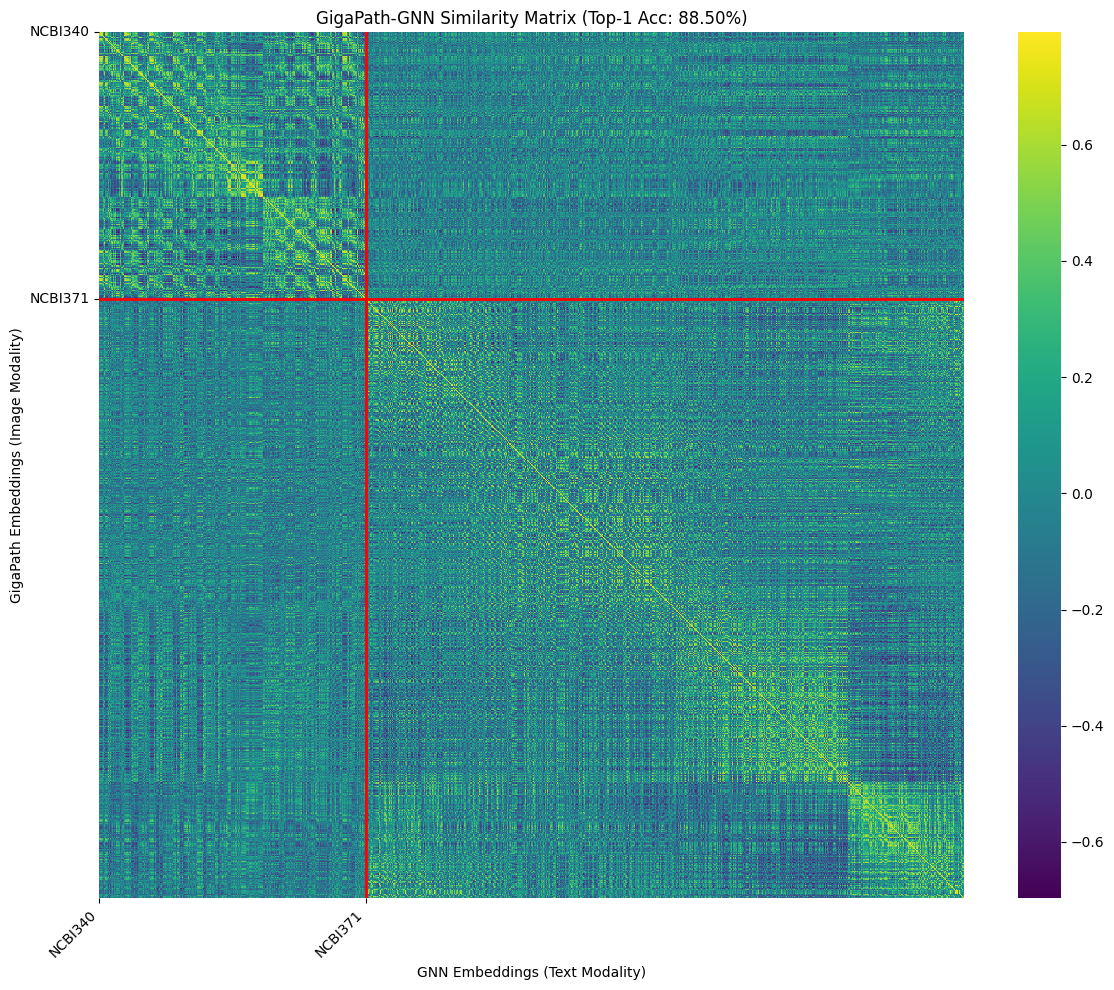

In [13]:
@torch.no_grad() # 确保在评估期间不计算梯度
def evaluate_and_visualize(model, graph_data_list, graph_info, device):
    """执行模型推理，计算相似度矩阵，并可视化结果。"""
    if not graph_data_list:
        print("没有可供评估的数据。")
        return

    # 1. 将所有加载的图合并成一个大批次 (Batch)
    batch = Batch.from_data_list(graph_data_list).to(device)
    total_nodes = batch.num_nodes

    print(f"\n--- 开始评估 ---")
    print(f"总计 {len(graph_data_list)} 个图, {total_nodes} 个节点将被处理。")

    # 2. 执行推理
    # 分别从两个模态获取所有节点的嵌入
    # "文本" 模态: GNN 处理图结构和节点特征
    print("正在通过 Graph Conditioner 生成 GNN 嵌入...")
    all_gnn_embeddings = model.graph_conditioner(batch)
    
    # "图像" 模态: GigaPath 特征通过 MLP 编码器
    print("正在通过 Gigapath Encoder 生成图像嵌入...")
    all_gigapath_features = batch.y # y 中存储着 GigaPath 特征
    all_image_embeddings = model.gigapath_encoder(all_gigapath_features)
    
    # 3. 归一化嵌入
    all_gnn_embeddings = F.normalize(all_gnn_embeddings, p=2, dim=-1)
    all_image_embeddings = F.normalize(all_image_embeddings, p=2, dim=-1)
    
    print("嵌入生成和归一化完成。")
    
    # 4. 计算相似度矩阵 (所有图像嵌入 vs 所有GNN嵌入)
    # 矩阵的 [i, j] 元素表示第 i 个节点的图像嵌入与第 j 个节点的GNN嵌入的相似度
    print("正在计算相似度矩阵...")
    similarity_matrix = all_image_embeddings @ all_gnn_embeddings.t()
    similarity_matrix = similarity_matrix.cpu().numpy() # 移动到 CPU 以便使用 numpy/matplotlib

    # 5. 计算指标
    # Top-1 准确率: 对于每个节点的图像嵌入，其最匹配的GNN嵌入是否来自同一个节点？
    retrieved_indices = np.argmax(similarity_matrix, axis=1)
    correct_matches = np.sum(retrieved_indices == np.arange(total_nodes))
    top1_accuracy = correct_matches / total_nodes
    
    # 平均相似度
    diag_similarity = np.mean(np.diag(similarity_matrix))
    # 计算非对角线元素的平均值
    off_diag_mask = ~np.eye(total_nodes, dtype=bool)
    off_diag_similarity = np.mean(similarity_matrix[off_diag_mask])

    print("\n--- 评估结果 ---")
    print(f"Top-1 检索准确率: {top1_accuracy:.2%} ({correct_matches}/{total_nodes} 个节点正确匹配)")
    print(f"正确配对的平均相似度 (对角线): {diag_similarity:.4f}")
    print(f"错误配对的平均相似度 (非对角线): {off_diag_similarity:.4f}")
    print(f"相似度差距 (越大越好): {diag_similarity - off_diag_similarity:.4f}")
    
    # 6. 可视化
    print("\n正在生成相似度热力图...")
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(similarity_matrix, cmap='viridis', ax=ax)
    
    # 在热力图上标记不同样本的边界
    current_node_idx = 0
    ticks, tick_labels = [], []
    for info in graph_info:
        # 在每个样本的开始处放置刻度
        ticks.append(current_node_idx)
        tick_labels.append(info['sample_id'])
        
        # 画出边界线
        if current_node_idx > 0:
            ax.axhline(current_node_idx, color='red', linewidth=2)
            ax.axvline(current_node_idx, color='red', linewidth=2)
        current_node_idx += info['num_nodes']
    
    # 设置刻度和标签
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels, rotation=0)
    
    ax.set_xlabel("GNN Embeddings (Text Modality)")
    ax.set_ylabel("GigaPath Embeddings (Image Modality)")
    ax.set_title(f"GigaPath-GNN Similarity Matrix (Top-1 Acc: {top1_accuracy:.2%})")
    
    plt.tight_layout()
    plt.show()


# --- 主执行流程 ---
try:
    # 1. 查找或指定 checkpoint
    if config_eval.SPECIFIC_CHECKPOINT_PATH:
        checkpoint_file = config_eval.SPECIFIC_CHECKPOINT_PATH
    else:
        checkpoint_file = find_latest_checkpoint(config_train)
    
    # 2. 加载模型
    model = load_model_for_inference(checkpoint_file, config_train, config_eval.DEVICE)
    
    # 3. 加载数据
    eval_graphs, eval_info = load_evaluation_data(config_train.GRAPH_DATA_DIR, config_eval.EVAL_SAMPLE_IDS)
    
    # 4. 运行评估和可视化
    evaluate_and_visualize(model, eval_graphs, eval_info, config_eval.DEVICE)

except (FileNotFoundError, ValueError) as e:
    print(f"\n错误: {e}")
except Exception as e:
    import traceback
    print("\n发生了一个意料之外的错误:")
    traceback.print_exc()

### KDE Plot

In [21]:
# 1. 将所有加载的图合并成一个大批次 (Batch)
device = torch.device(config_eval.DEVICE)
graph_data_list = eval_graphs  # 直接使用加载的图数据
batch = Batch.from_data_list(graph_data_list).to(device)
total_nodes = batch.num_nodes

print(f"\n--- 开始评估 ---")
print(f"总计 {len(graph_data_list)} 个图, {total_nodes} 个节点将被处理。")

# 2. 执行推理
# 分别从两个模态获取所有节点的嵌入
# "文本" 模态: GNN 处理图结构和节点特征
print("正在通过 Graph Conditioner 生成 GNN 嵌入...")
all_gnn_embeddings = model.graph_conditioner(batch)

# "图像" 模态: GigaPath 特征通过 MLP 编码器
print("正在通过 Gigapath Encoder 生成图像嵌入...")
all_gigapath_features = batch.y # y 中存储着 GigaPath 特征
all_image_embeddings = model.gigapath_encoder(all_gigapath_features)


print("正在计算相似度矩阵...")
similarity_matrix = all_image_embeddings @ all_gnn_embeddings.t()
similarity_matrix = similarity_matrix.detach().cpu().numpy() # 移动到 CPU 以便使用 numpy/matplotlib


--- 开始评估 ---
总计 2 个图, 896 个节点将被处理。
正在通过 Graph Conditioner 生成 GNN 嵌入...
正在通过 Gigapath Encoder 生成图像嵌入...
正在计算相似度矩阵...



--- 可视化方案 1: 相似度分布图 ---


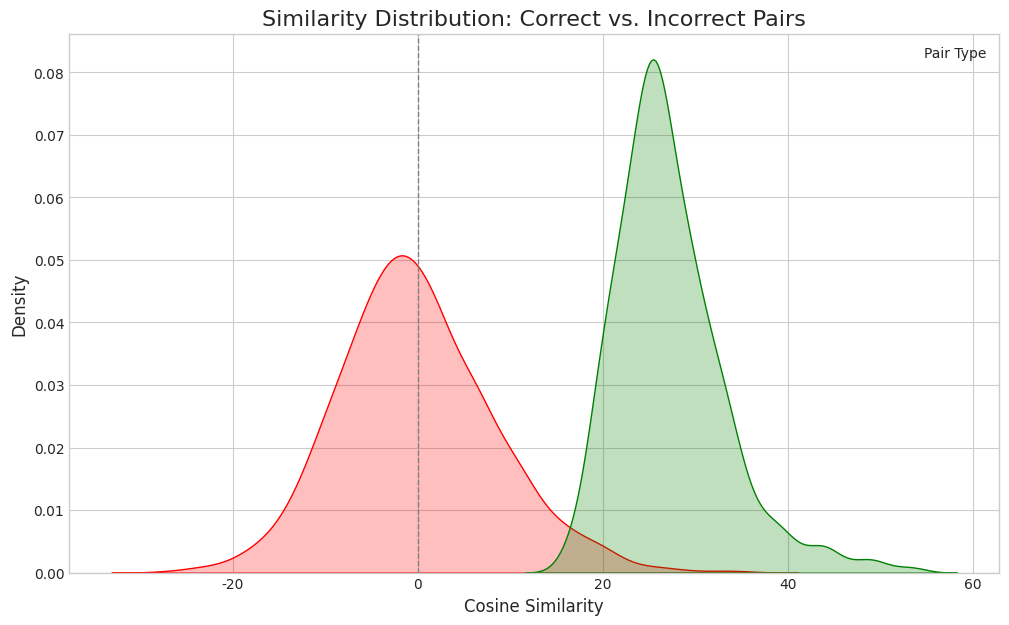

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set font that supports Chinese characters for macOS
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("\n--- 可视化方案 1: 相似度分布图 ---")

# 1. 提取正确配对和错误配对的相似度分数
correct_similarities = np.diag(similarity_matrix)
total_nodes = similarity_matrix.shape[0]
off_diag_mask = ~np.eye(total_nodes, dtype=bool)
incorrect_similarities = similarity_matrix[off_diag_mask]

# 为了绘图，从错误配对中随机抽样，避免数量过多导致绘图缓慢
# 抽样数量可以和正确配对的数量相当
if len(incorrect_similarities) > len(correct_similarities) * 2:
    incorrect_similarities_sample = np.random.choice(
        incorrect_similarities, 
        size=len(correct_similarities) * 2, 
        replace=False
    )
else:
    incorrect_similarities_sample = incorrect_similarities

# 2. 创建 DataFrame 以便使用 seaborn 绘图
df_correct = pd.DataFrame({'Similarity': correct_similarities, 'Type': 'Correct Pair'})
df_incorrect = pd.DataFrame({'Similarity': incorrect_similarities_sample, 'Type': 'Incorrect Pair'})
similarity_df = pd.concat([df_correct, df_incorrect])

# 3. 使用 Seaborn 绘制 KDE 图
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
sns.kdeplot(data=similarity_df, x='Similarity', hue='Type', fill=True, 
            common_norm=False, palette={'Correct Pair': 'g', 'Incorrect Pair': 'r'})

plt.title('Similarity Distribution: Correct vs. Incorrect Pairs', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.legend(title='Pair Type')
plt.show()

### TSNE

In [ ]:
from sklearn.manifold import TSNE
import umap # 使用 UMAP，通常效果更好更快

print("\n--- 可视化方案 2: UMAP 嵌入空间可视化 ---")

# 1. 准备数据和标签
# 合并两种模态的嵌入
all_embeddings = np.concatenate([
    all_image_embeddings.cpu().numpy(), 
    all_gnn_embeddings.cpu().numpy()
], axis=0)

# 创建标签
# a) 模态标签 (Image vs GNN)
modality_labels = ['Image'] * total_nodes + ['GNN'] * total_nodes

# b) 样本ID标签 (NCBI340 vs NCBI371)
sample_id_labels = []
for info in graph_info:
    sample_id_labels.extend([info['sample_id']] * info['num_nodes'])
sample_id_labels = sample_id_labels * 2 # 两种模态，所以标签要重复一次

# 2. 运行 UMAP 进行降维
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
print("正在对所有嵌入进行 UMAP 降维...")
embeddings_2d = reducer.fit_transform(all_embeddings)

# 3. 创建 DataFrame
df_2d = pd.DataFrame(embeddings_2d, columns=['UMAP_1', 'UMAP_2'])
df_2d['Modality'] = modality_labels
df_2d['Sample ID'] = sample_id_labels

# 4. 绘图
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
plt.suptitle('嵌入的二维UMAP可视化', fontsize=20)

# 图a: 按样本ID着色
sns.scatterplot(data=df_2d, x='UMAP_1', y='UMAP_2', hue='Sample ID', style='Modality', 
                s=50, alpha=0.7, ax=axes[0])
axes[0].set_title('按样本ID着色', fontsize=16)
axes[0].legend(title='图例', markerscale=1.5)
axes[0].grid(True)

# 图b: 按模态着色
sns.scatterplot(data=df_2d, x='UMAP_1', y='UMAP_2', hue='Modality', style='Sample ID', 
                s=50, alpha=0.7, ax=axes[1])
axes[1].set_title('按模态着色', fontsize=16)
axes[1].legend(title='图例', markerscale=1.5)
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()